In [6]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std


In [7]:
# 2 choices

# 1. with simulator on nicelab, user lvm
#   RMQ_HOST=$(minikube ip) ipython3
#   paste the code

# 2. local with image eg from nicelab:  /data/lvm/sci/agcam/east/20220927/lvm.sci.agcam.east_00003730.fits
#    python > 3.8
#    pip3 install sdss-lvmagp astrometry
#    ipython3

from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [8]:

import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

await lvm.sci.foc.start()
await lvm.sci.foc.status()

try:
    await lvm.sci.pwi.start()
    await lvm.sci.pwi.setConnected(True, statusTick=1.0)
    await lvm.sci.pwi.status()

except Exception as ex:
    print(ex)

await lvm.sci.agc.start()



In [139]:
import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

# Load images

In [185]:
exptime = 5

rc = await lvm.sci.agc.expose( exptime)
filenames = rc.flatten().unpack("*.filename")
print(filenames)


['/data/lvm/sci/agcam/east/20230221/lvm.sci.agcam.east_00000027.fits', '/data/lvm/sci/agcam/center/20230221/lvm.sci.agcam.center_00000027.fits', '/data/lvm/sci/agcam/west/20230221/lvm.sci.agcam.west_00000027.fits']


In [186]:
with fits.open(filenames[0]) as hdul:
    data_east = hdul[0].data
    

with fits.open(filenames[1]) as hdul:
    data_center = hdul[0].data    
    
with fits.open(filenames[2]) as hdul:
    data_west = hdul[0].data
    

    
data_center_binned = (data_center[::2,::2].astype(float)+data_center[1::2,::2].astype(float)+data_center[::2,1::2].astype(float)+data_center[1::2,1::2].astype(float))/4

In [187]:
image_list = [data_east,data_center_binned,data_west]

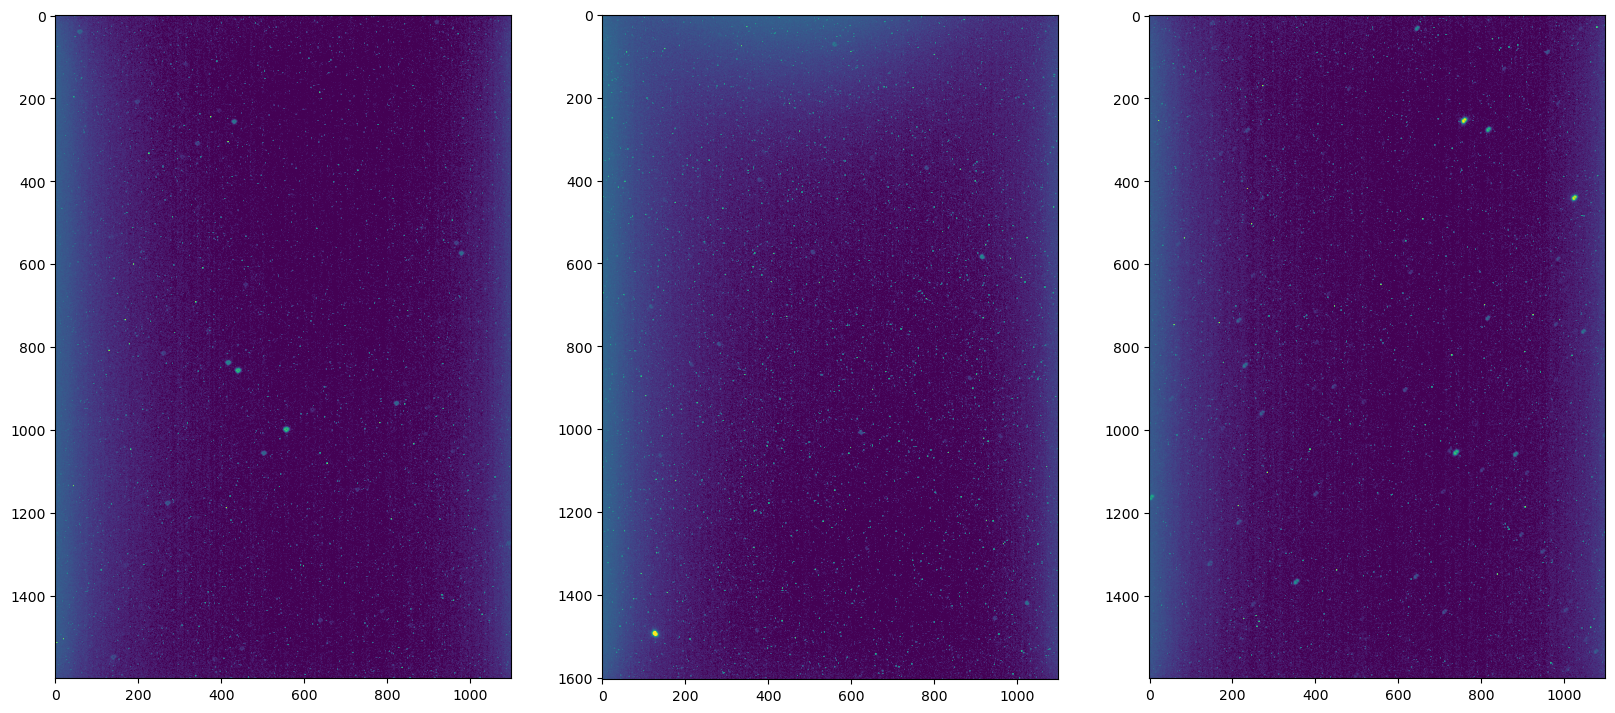

In [188]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(20,10),ncols=3)

ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=10000))
ax2.imshow(data_center_binned.T,norm=LogNorm(vmin=50, vmax=10000))
ax3.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=10000))

# Run DAOphot and Astrometry

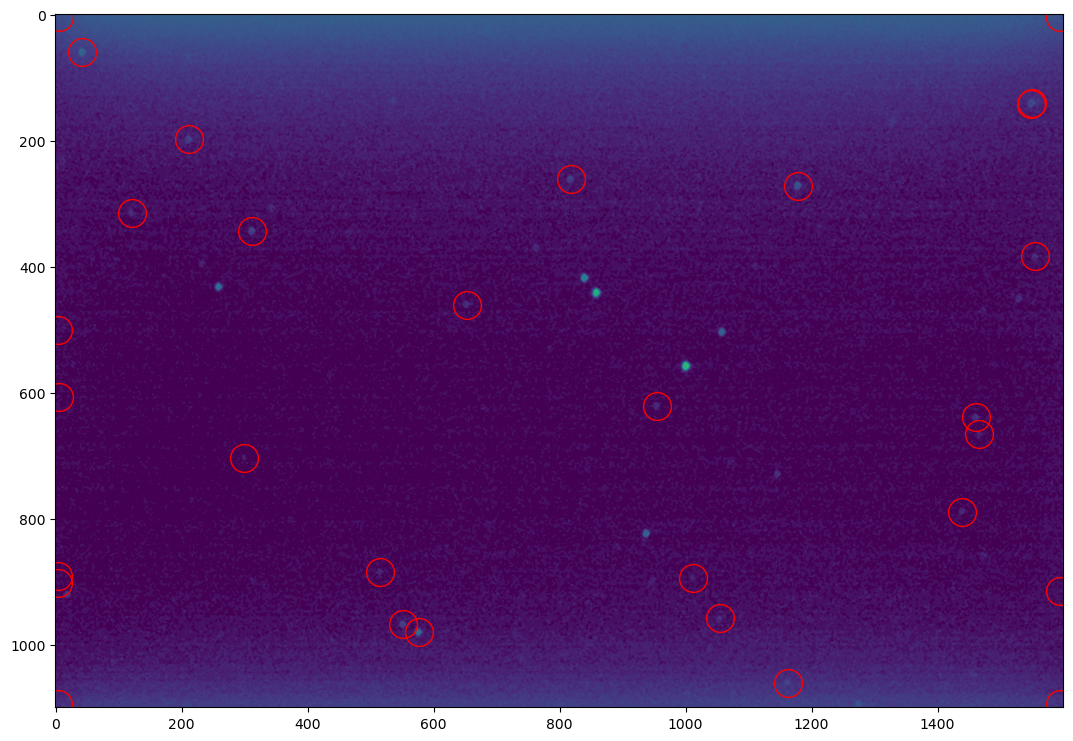

solution.best_match().center_ra_deg=95.00018077556699
solution.best_match().center_dec_deg=-52.527370315307685
solution.best_match().scale_arcsec_per_pixel=1.0067973192789408
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 94.92523353977236  -52.42069295877781  
CRPIX : 390.3684684263603  488.4896775438963  
CD1_1 CD1_2  : 7.16684373094815e-05  0.000269999569148191  
CD2_1 CD2_2  : -0.00027052650847824  7.21515272581516e-05  
NAXIS : 0  0


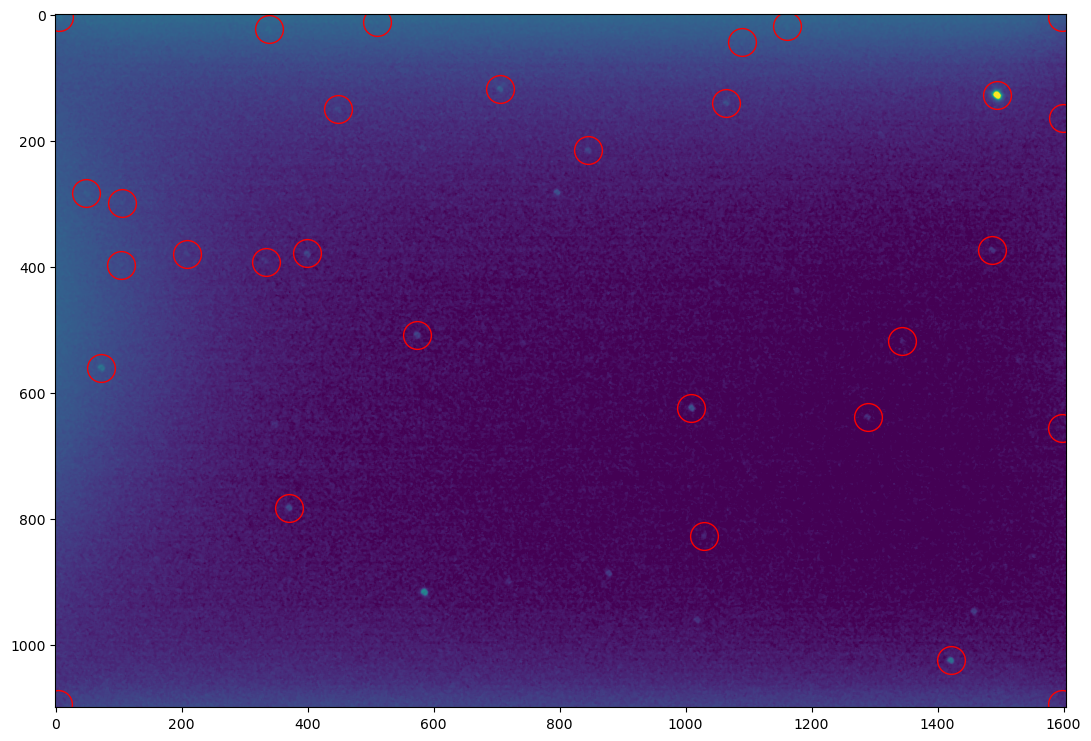

solution.best_match().center_ra_deg=95.80613697303932
solution.best_match().center_dec_deg=-52.40000994664996
solution.best_match().scale_arcsec_per_pixel=1.008680576596843
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 95.92214768823882  -52.51535382591069  
CRPIX : 337.2949954353602  418.5848213442226  
CD1_1 CD1_2  : -7.5742157213775e-05  -0.00026958670615003  
CD2_1 CD2_2  : 0.000269782206024593  -7.6261452308559e-05  
NAXIS : 0  0


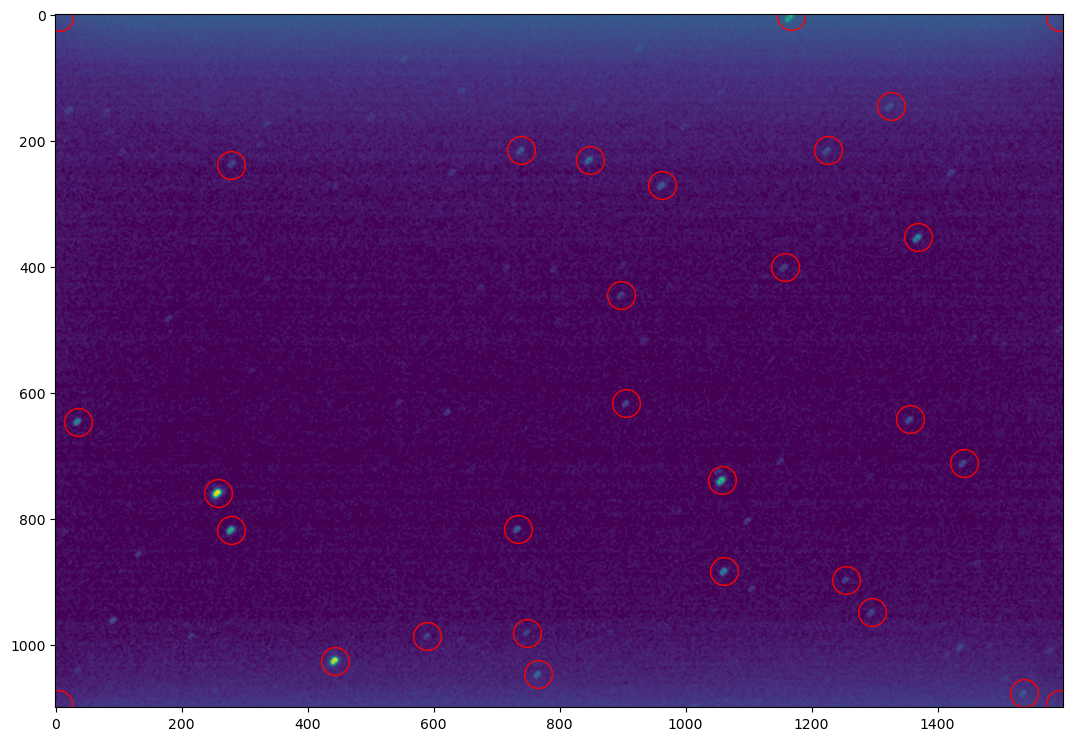

solution.best_match().center_ra_deg=96.57376145188022
solution.best_match().center_dec_deg=-52.26910762443895
solution.best_match().scale_arcsec_per_pixel=1.0073210314047523
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 96.52865517854455  -52.2570481952183  
CRPIX : 731.2421564881917  631.6480163145063  
CD1_1 CD1_2  : 7.70155606915771e-05  -0.00026907770427361  
CD2_1 CD2_2  : -0.00026898053791365  -7.6838401805983e-05  
NAXIS : 0  0


In [189]:
wcs_results = []
touple_list = []

for image_orig in image_list:
    image = median_filter(image_orig,size=4)#gaussian_filter(image_orig,sigma=5)
    bkg_sigma = mad_std(image)  
    #image_orig[image_orig>60000] = float("nan")
    daofind = DAOStarFinder(fwhm=10, threshold=3 * bkg_sigma)
    sources = daofind(image)  

    sources.sort("flux")
    sources.reverse()
    sources = sources[:30]

    for col in sources.colnames:  

        sources[col].info.format = '%.8g'  # for consistent table output

    #print(sources)  
    fig,ax1 = plt.subplots(figsize=(16,9))

    ax1.imshow(image,norm=LogNorm(vmin=50, vmax=10000))
    ax1.plot(sources["xcentroid"],sources["ycentroid"],"o",markerfacecolor="none",markeredgecolor="r",ms=20)
    plt.show()

    logodds_callback = astrometry.Action.STOP

    solution = solver.solve(
    stars_xs=sources['xcentroid'],
    stars_ys=sources['ycentroid'],
    size_hint=astrometry.SizeHint(
        lower_arcsec_per_pixel=0.9,#arcsec_per_pixel-0.1,
        upper_arcsec_per_pixel=1.1,#arcsec_per_pixel+0.1,
    ),
    position_hint=None,
    #position_hint=astrometry.PositionHint(
    #    ra_deg=57.4,
    #    dec_deg=24.15,
    #    radius_deg=5,
    #),
    #solve_id=None,
    #tune_up_logodds_threshold=None,#14.0, # None disables tune-up (SIP distortion)
    #output_logodds_threshold=21.0,
    #logodds_callback=lambda logodds_list: logodds_callback
    solution_parameters=astrometry.SolutionParameters(
        logodds_callback=lambda logodds_list: astrometry.Action.STOP,
    ),
    )
    #log.debug("Solve done")

    if solution.has_match():
        print(f"{solution.best_match().center_ra_deg=}")
        print(f"{solution.best_match().center_dec_deg=}")
        print(f"{solution.best_match().scale_arcsec_per_pixel=}")
        wcs = astropy.wcs.WCS(solution.best_match().wcs_fields)
        wcs_results.append(wcs)
        touple_list.append((image_orig,wcs))
        pixels = wcs.all_world2pix(
            [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
            0,
        )
        print(f"{wcs}")
    else:
        print("No Match!")

In [171]:
wcs_east = wcs_results[0]
wcs_center = wcs_results[1]
wcs_west = wcs_results[2]

In [172]:
east_center = wcs_east.pixel_to_world(1600//2,1100//2)
west_center = wcs_west.pixel_to_world(1600//2,1100//2)
center_center = wcs_center.pixel_to_world(1600//2,1100//2)

In [173]:
pa = east_center.position_angle(west_center)

sep = east_center.separation(west_center)

midpoint = west_center.directional_offset_by(pa, -sep/2) 

In [174]:
ras = [east_center.ra.value]
decs = [east_center.dec.value]

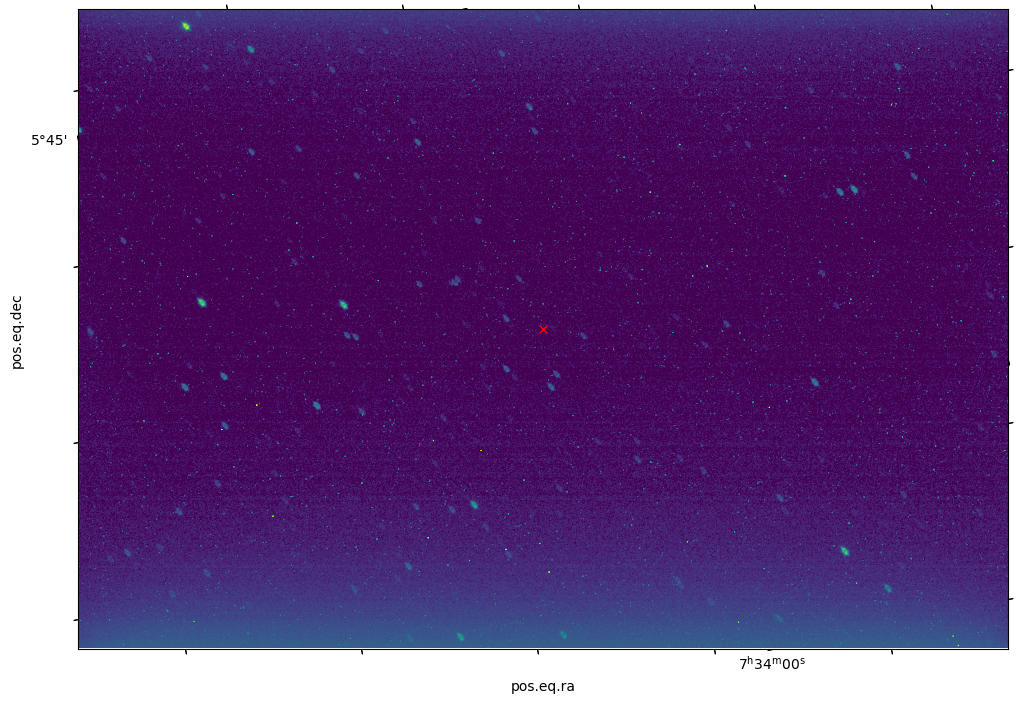

In [175]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(projection=wcs_east)
ax1.imshow(image_list[0], norm=LogNorm(vmin=50, vmax=10000))
ax1.plot(800,550,"rx")


In [176]:
touple_list

[(array([[144, 208, 176, ..., 208, 144, 208],
         [176, 192, 192, ..., 160, 192, 224],
         [144, 176, 192, ..., 144, 176, 160],
         ...,
         [112,  64, 112, ...,  80,  80, 128],
         [ 96,  96,  96, ...,  80, 112,  80],
         [128, 176, 112, ..., 128, 144,  96]], dtype=uint16),
  WCS Keywords
  
  Number of WCS axes: 2
  CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
  CRVAL : 113.7058060915756  5.536176579142022  
  CRPIX : 822.9246318903638  670.3348841852118  
  CD1_1 CD1_2  : -5.7262627497111e-05  0.000274464483918897  
  CD2_1 CD2_2  : -0.0002741350759918  -5.7263559697581e-05  
  NAXIS : 0  0),
 (array([[240., 216., 216., ..., 240., 228., 176.],
         [260., 240., 240., ..., 196., 164., 180.],
         [164., 204., 204., ..., 152., 200., 184.],
         ...,
         [136., 108., 100., ..., 428., 104., 104.],
         [120., 212.,  64., ..., 100., 136., 112.],
         [100.,  84., 132., ..., 128., 132., 112.]]),
  WCS Keywords
  
  Number of WCS axes: 2
 

# Reproject images'

In [177]:
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out= reproject.mosaicking.find_optimal_celestial_wcs(touple_list)

reprojected_arrays = []
footprints = []
for index,touple in enumerate(touple_list):
    print(index)
    

    reprojected_array,current_footprint = reproject.reproject_interp(touple, wcs_out, shape_out=shape_out)
    reprojected_arrays.append(reprojected_array)
    footprints.append(current_footprint)

0


[WARNING]: 'WCS.all_world2pix' failed to converge to the requested accuracy. (UserWarning)
After 20 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))



1
2


In [178]:
stack = np.array(reprojected_arrays)
stack_combined = np.nanmedian(stack,axis=0)
footprints_sum = np.sum(np.array(footprints),axis=0)

[WARNING]: All-NaN slice encountered (RuntimeWarning)
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



In [179]:
center_center.ra.value

114.17045079727538

In [180]:
pix_midpoint = wcs_out.world_to_pixel(midpoint)

In [181]:
pix_midpoint

(array(2437.64489386), array(1276.05413322))

In [182]:
pix_array = np.array([wcs_out.world_to_pixel(center_center),wcs_out.world_to_pixel(west_center),wcs_out.world_to_pixel(east_center)])

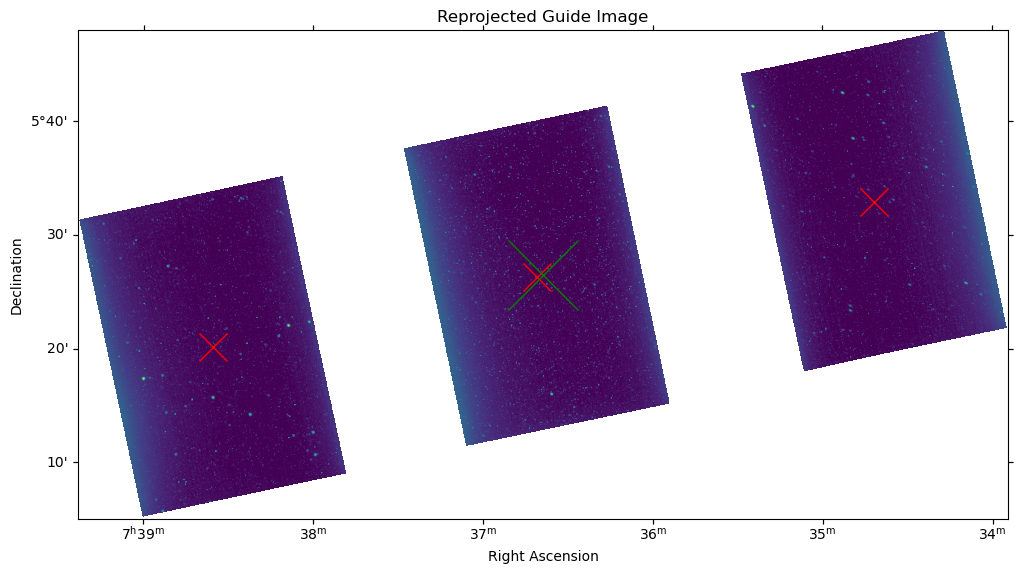

In [183]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(projection=wcs_out)
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
#ax1.plot(gaia_pixel_repro[0],gaia_pixel_repro[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected Guide Image')

ax1.plot(pix_array[:,0],pix_array[:,1],"rx",ms=20)

ax1.plot(pix_midpoint[0],pix_midpoint[1],"gx",ms=50)


In [128]:
midpoint.ra.hour

5.554730164827567

In [129]:
midpoint.dec.deg

-5.106022577770433

In [184]:
await lvm.sci.pwi.modelAddPoint(midpoint.ra.hour,midpoint.dec.deg)

{'model': {'filename': '2023-02-16-lco-skyw-7.pxp',
  'num_points_enabled': 13,
  'num_points_total': 14,
  'rms_error_arcsec': 1107.42594702486}}

# Load and show Gaia stars 

In [ ]:
import astropy.units as u
from astroquery.gaia import Gaia

In [ ]:
#my_wcs = wcs_out
c_icrs = wcs_out.pixel_to_world(shape_out[1]//2,shape_out[0]//2)
radius = u.Quantity(0.8, u.deg)
remote_maglim=12
#j = Gaia.cone_search_async(coordinate=c_icrs, radius)
gaia_query = "SELECT source_id, ra,dec,phot_g_mean_mag FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag <= "+str(remote_maglim)+" AND 1=CONTAINS(POINT('ICRS',ra,dec), CIRCLE('ICRS',"+str(c_icrs.ra.deg)+","+str(c_icrs.dec.deg)+", "+str(radius.value)+"))"
print("Gaia query: ",gaia_query)
j = Gaia.launch_job_async(gaia_query)
cat = j.get_results()
#print("Gaia query: ",gaia_query)
print(f'{len(cat)} stars found within {radius}')


Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
#gaia_pixel_orig = wcs.world_to_pixel(Gaiastars)
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
        
gaia_selection = (0 < gaia_pixel[0]) & (gaia_pixel[0] < shape_out[1]) & (0 < gaia_pixel[1]) & (gaia_pixel[1] < shape_out[0])
cat = cat[gaia_selection]
Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
print("{} of these are actually in the FOV".format(len(cat)))

In [ ]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(projection=wcs_results[0])
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
ax1.plot(gaia_pixel[0],gaia_pixel[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
#ax1.coords['ra'].set_axislabel('Right Ascension')
#ax1.coords['dec'].set_axislabel('Declination')
#ax1.set_title('2MASS K-band')

for index,entry in enumerate(cat):
    ax1.text(gaia_pixel[0][index]+25,gaia_pixel[1][index],"{:.1f}".format(entry["phot_g_mean_mag"]),color="w",alpha=0.8)
    
#ax1.set_xlim(0,1600)
#ax1.set_ylim(0,1100)

In [ ]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
im1 = ax1.imshow(stack_combined, origin='lower', vmin=100, vmax=10000)
ax1.set_title('Mosaic')
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(footprints_sum, origin='lower')
ax2.set_title('Footprint')

In [ ]:
header = wcs_out.to_header()
hdu = fits.PrimaryHDU(stack_combined,header=header)


hdul = fits.HDUList([hdu])
hdul.writeto('full_mater_mosaic.fits',overwrite=True)